# Imports dataset from google cloud storage 

In [0]:
from google.colab import auth 

auth.authenticate_user()

!gsutil -m cp gs://csitproject/dataset/articles.json .

# Imports necessary utils and loads data

In [0]:
!pip install corextopic

In [0]:
import gensim
import json
import nltk
import numpy as np
import csv
import scipy.sparse as ss
from corextopic import corextopic as ct
from corextopic import vis_topic as vt
from collections import Counter
from matplotlib import pyplot as plt
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *

In [0]:
with open('articles.json', 'r') as file:
    data = json.load(file)

nltk.download('wordnet')
contents = [article["contents"] for article in data]

# Preprocesses the data

In [0]:
## Appends articles with negative sentiment 
contents = [article["contents"] for article in data if article["sentiment"] == -1]

## Lemmatize
def lemmatize(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')

## Preprocess the text using lemmatization, tokenization and stopword removal
def preprocess(text):
    result=[]
    for token in simple_preprocess(text) :
        if token not in STOPWORDS and len(token) > 3:
            result.append(lemmatize(token))

    return result

## Create BOW from the documents.
## Remove very rare and very common words: words appearing less than 15 times and words appearing in more than 10% of all documents
def bag_of_words(text):
    dictionary = gensim.corpora.Dictionary(text)
    dictionary.filter_extremes(no_below=10, no_above=0.2, keep_n= 10000)
    return dictionary



In [0]:
## Creates preprocessed docs, word2id dict, id2word dict, vocab and BOW sparse matrix 
word2id = {}

preprocessed = [preprocess(doc) for doc in contents]
cnt = Counter()
for doc in preprocessed:
  for word in doc:
    cnt[word] += 1
id2word = bag_of_words(preprocessed)
word2id = {v: k for k, v in id2word.items()}
vocab = [word for word, count in cnt.most_common()]
    
X = np.zeros((len(preprocessed), len(word2id)),dtype=int)
final_docs = []

for doc in preprocessed:
    currentDoc = [word2id[word] for word in doc if word in word2id]
    final_docs.append(currentDoc)

for idx, doc in enumerate(final_docs):
    for idy in doc:
        X[idx,idy] += 1

# Model Training and hyperparameter tuning 

In [16]:
## Runs model training 
X = ss.csr_matrix(X)
topic_model = ct.Corex(n_hidden=30)  # Define the number of latent (hidden) topics to use.
topic_model.fit(X)
print(topic_model.tc)

15.277371360249854


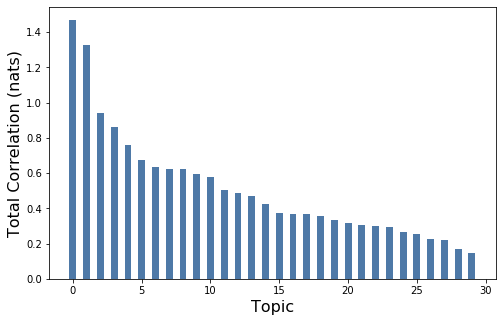

In [17]:
## Plot correlation against number of topics to identify optimum clustering 
plt.figure(figsize=(8,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

In [18]:
## Runs model training on identified anchor words and more optimal number of clusters
topic_model_2 = ct.Corex(n_hidden=5)
anchor_words = [["die", "death", "concussion", "death", "suffer"], ["apology", "disruptive", "scream", "upset", "boycott"],
 ["industry", "business", "bank", "market", "dollars"], ["lawsuit", "attorney", "allege", "complaint", "damage"]]
keys = [k for k in word2id]
topic_model_2.fit(X, words=keys, docs=docs)
print(topic_model_2.tc)

13.909692525120139


In [19]:
## Generates topics from closest words 
top = topic_model_2.set_words(vocab)
topics = topic_model_2.get_topics(n_words=20)
for topic_n, topic in enumerate(topics):
    words,probs = zip(*topic)
    words = [id2word[word] for word in words if word in id2word]
    topic_str = str(topic_n+1)+': '+','.join(words)
    print(topic_str)

1: volunteer,enforcement,voluntarily,apologize,outrage,aisle,team,hospital,stock,bridge,asian,situation,room,bloody,choose,detail,random,price,treat,chief,authorities,scream,defend,boycott,hand,give,pull,hare,reach,question
2: service,long,thursday,number,delta,base,meet,share,state,american,week,draw,recently,decision,fight,president,industry,global,percent,things,reputation,large,destination,month,experience,instead,getty,fail,incidents,corporate
3: family,die,march,carrier,hold,york,continental,prevent,order,years,fly,image,recent,reuters,pet,overhead,money,owner,course,executive,group,remain,carry,make,value,file,book,cost,attendant,caption
4: crew,belligerent,disruptive,members,patients,kentucky,break,aviation,place,tuesday,occur,express,arm,staff,later,aboard,identify,department,damage,involve,children,photo,email,responsibility,lawsuit,action,send,backlash,speak,head
5: face,review,accommodate,nose,upset,trump,teeth,concussion,conduct,policy,lose,court,event,hear,learn,night,rec

In [44]:
## Generates closest documents to each topic 
top_docs = topic_model_2.get_top_docs(3)
for topic_n, topic_docs in enumerate(top_docs):
    docs,probs = zip(*topic_docs)
    topic_str = str(topic_n+1)+': '+','.join(str(doc) for doc in docs)
    print(topic_str)

1: ['pervert', 'impossible', 'accuse', 'touch', 'genitals', 'latest', 'unite', 'airlines', 'scandal', 'news', 'staff', 'original', 'article', 'post', 'pageturner', 'post', 'reply', 'unite', 'airlines', 'issue', 'public', 'apology', 'mistreat', 'customer', 'time', 'airline', 'say', 'sorry', 'father', 'accuse', 'have', 'hand', 'close', 'genitals', 'flight', 'attendant', 'passenger', 'henry', 'amador', 'batten', 'accuse', 'inappropriately', 'touch', 'flight', 'puerto', 'rico', 'detain', 'north', 'carolina', 'raleigh', 'durham', 'international', 'airport', 'hour', 'incident', 'unite', 'suffer', 'number', 'high', 'profile', 'public', 'relations', 'catastrophes', 'recent', 'months', 'begin', 'video', 'surface', 'online', 'bloody', 'passenger', 'drag', 'plane', 'indonesia', 'probe', 'suicide', 'attack', 'kill', 'policemen', 'channel', 'news', 'asia', 'singapore', 'staff', 'original', 'article', 'post', 'pageturner', 'post', 'reply', 'jakarta', 'indonesia', 'elite', 'anti', 'terror', 'squad', 

In [0]:
keys = [k for k in word2id]
vt.vis_rep(topic_model_2, column_label=keys, prefix='topic-model-example')

# Determination of most recurring themes 

In [39]:
accidents = ["die", "death", "concussion", "death", "suffer"]
customer = ["apology", "disruptive", "scream", "upset", "boycott"]
business = ["industry", "business", "bank", "market", "dollars"]
controversy = ["lawsuit", "attorney", "allege", "complaint", "damage"]

acc_cnt = 0
cus_cnt = 0
econ_cnt = 0
manag_cnt = 0

for i in accidents: 
  if i in cnt.keys():
    acc_cnt += cnt[i]

for i in customer:
  if i in cnt.keys():
    cus_cnt += cnt[i]

for i in business:
  if i in cnt.keys():
    econ_cnt += cnt[i]

for i in controversy:
  if i in cnt.keys():
    manag_cnt += cnt[i]

print("Accidents, Customers, Economics and Managerial problem scores are in order: " + str(acc_cnt) + ',' + str(cus_cnt) + ',' + str(econ_cnt) + ',' + str(manag_cnt))

Accidents, Customers, Economics and Managerial problem scores are in order: 7210,11525,16008,11038
